# DQN

The goal of this exercise is to implement DQN and to apply it to the cartpole balancing problem. 

Let's import eveything we need to run gym on Colab:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from collections import deque
from IPython.display import clear_output

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
    
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if not IN_COLAB:
    import gym
    def show_video():
        pass
    def wrap_env(env):
        return env
else:
    # Installing Debian and pip packages. It can take a while.
    # remove " > /dev/null 2>&1" to see what is going on under the hood
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !apt-get update > /dev/null 2>&1
    !apt-get install cmake > /dev/null 2>&1
    !pip install box2d > /dev/null 2>&1
    !pip install gym[box2d] > /dev/null 2>&1
    !pip install gym[atari]
    
    import gym

    from gym.wrappers import Monitor
    import random, math, glob, io, base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

    def show_video():
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
        else: 
            print("Could not find video")

    def wrap_env(env):
        env = Monitor(env, './video', force=True)
        return env


## Cartpole balancing task

We are going to use the Cartpole balancing problem, which can be loaded with:

```python
env = wrap_env(gym.make('CartPole-v0'))
```

States have 4 continuous values (position and speed of the cart, angle and speed of the pole) and 2 discrete outputs (going left or right). The reward is +1 for each transition where the pole is still standing (angle of less than 30° with the vertical). The episode ends when the pole fails or after 200 steps. The maximal (undiscounted) return is therefore 200. Can DQN learn this?

In [2]:
# Create the environment
env = wrap_env(gym.make('CartPole-v0'))

# Sample the initial state
state = env.reset()

# One episode:
done = False
return_episode = 0
while not done:
    
    # Render the current state
    env.render()

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, done, info = env.step(action)

    # Update undiscounted return
    return_episode += reward
    
    # Go in the next state
    state = next_state

print("Return:", return_episode)

# Exit cleanly
env.close()
show_video()

Return: 12.0


As the problem is quite simple (4 state variables, 2 actions), DQN can run on a single CPU. However, we advise that you run the notebook on a GPU in Colab to avoid emptying the battery of your laptop too fast or making it too warm as training takes quite a long time.

We will forget from now on to display the cartpole on colab, it does not work well.

## Creating the model

The first step is to create the value network using `keras`. We will not need anything fancy: a simple fully connected network with 4 input neurons, two hidden layers of 64 neurons each and 2 output neurons will do the trick. ReLU activation functions all along and the Adam optimizer.

**Q:** Which loss function should we use? Think about which arguments have to passed to `model.compile()` and what activation function is required in the output layer.

We will need to create two identical networks: the trained network and the target network. You should therefore create a method that returns a compiled model, so it can be called two times. You should pass it the environment (so the network can know how many input and output neurons it needs) and the learning rate for the Adam optimizer.

```python
def create_model(env, lr):
    
    model = Sequential()

    # ...

    return model
```

**Q:** Implement the method accordingly.

In [3]:
def create_model(env, lr):
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Input(env.observation_space.shape))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(env.action_space.n, activation='linear'))
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=lr))
    
    print(model.summary())

    return model

Let's test this method by creating the trained and target networks.

**Important:** every time you call `create_model`, a new neural network will be instantiated but the previous ones will not be deleted. During this exercise, you may have to create hundreds of networks because of the incremental implementation of DQN: all networks will stay instantiated in the RAM, and your computer/colab tab will freeze after a while. Before creating new networks, delete all existing ones with:

```python
tf.keras.backend.clear_session()
```

**Q:** Create the trained and target networks. The learning rate does not matter for now. Instantiate the Cartpole environment and print the output of both networks for the initial state (`state = env.reset()`). Are they the same?

*Hint:* `model.predict()` expects an array of shape (N, 4), with N the number of examples. Here, we have only one example, so make sure to reshape `state` so it has the shape (1, 4) (otherwise tf will complain).

In [4]:
env = gym.make('CartPole-v0')

state = env.reset()
print("State:", state)

tf.keras.backend.clear_session()
trained_model = create_model(env, 0.001)
target_model = create_model(env, 0.001)

trained_prediction = trained_model.predict(state.reshape((1, env.observation_space.shape[0])))[0]
target_prediction = target_model.predict(state.reshape((1, env.observation_space.shape[0])))[0]
print("Predictions:", trained_prediction, target_prediction)

State: [-0.01228574  0.00488752  0.02812964 -0.00934043]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 

The target network has the same structure as the trained network, but not the same weights, as they are randomly initialized. We want the target network $\theta'$ to have exactly the same weights as the trained weights $\theta$. You can obtain the weights of a network with:

```python
w = model.get_weights()
```

and set weights using:

```python
model.set_weights(w)
```

**Q:** Transfer the weights of the trained model to the target model. Compare their predictions for the current state.

In [5]:
target_model.set_weights(trained_model.get_weights())

trained_prediction = trained_model.predict(state.reshape((1, env.observation_space.shape[0])))[0]
target_prediction = target_model.predict(state.reshape((1, env.observation_space.shape[0])))[0]
print("Predictions:", trained_prediction, target_prediction)

Predictions: [-0.0029409   0.00551502] [-0.0029409   0.00551502]


## Experience replay memory

The second thing that we need is the experience replay memory (or replay buffer). We need a container like a python list where we append (s, a, r, s', done) transitions (as in Q-learning), but with a maximal capacity: when there are already $C$ transitions in the list, one should stop appending to the list, but rather start writing at the beginning of the list.

This would not be very hard to write, but it would take a lot of time and the risk is high to have hard-to-notice bugs. 

Here is a basic implementation of the replay buffer using **double-ended queues** (deque). A deque is list with a maximum capacity. If the deque is full, it starts writing again at the beginnning. Exactly what we need. This implementation uses one deque per element in (s, a, r, s', done), but one could also append the whole transition to a single deque.

**Q:** Read the code of the ReplayBuffer and understand what it does.

In [6]:
class ReplayBuffer:
    "Basic implementation of the experience replay memory using separated deques."
    def __init__(self, max_capacity):
        self.max_capacity = max_capacity
        
        # deques for each element
        self.states = deque(maxlen=max_capacity)
        self.actions = deque(maxlen=max_capacity)
        self.rewards = deque(maxlen=max_capacity)
        self.next_states = deque(maxlen=max_capacity)
        self.dones = deque(maxlen=max_capacity)
        
    def append(self, state, action, reward, next_state, done):
        # Store data
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        
    def sample(self, batch_size):
        # Do not return samples if we do not have at least 2*batch_size transitions
        if len(self.states) < 2*batch_size: 
            return []
            
        # Randomly choose the indices of the samples.
        indices = sorted(np.random.choice(np.arange(len(self.states)), batch_size, replace=False))

        # Return the corresponding
        return [np.array([self.states[i] for i in indices]), 
                np.array([self.actions[i] for i in indices]), 
                np.array([self.rewards[i] for i in indices]), 
                np.array([self.next_states[i] for i in indices]), 
                np.array([self.dones[i] for i in indices])]

**Q:** Run a random agent on Cartpole for a few episodes and append each transition to a replay buffer with small capacity (e.g. 100) and sample batches from time to time. Check that everything makes sense.

In [7]:
env = gym.make('CartPole-v0')

buffer = ReplayBuffer(100)

for episode in range(10):
            
    # Reset
    state = env.reset()
    done = False
    
    # Sample the episode
    while not done:
        
        # Select an action randomly
        action = env.action_space.sample()
            
        # Perform the action
        next_state, reward, done, info = env.step(action)
                
        # Store the transition
        buffer.append(state, action, reward, next_state, done)
                
        # Go in the next state
        state = next_state
    
    # Sample a minibatch
    batch = buffer.sample(10)
    print(batch)

[]
[array([[-0.04588702,  0.17571342, -0.04359217, -0.26982999],
       [-0.03494416,  0.56720267, -0.06050751, -0.88364164],
       [-0.02360011,  0.37295228, -0.07818034, -0.61057763],
       [-0.01614106,  0.56907494, -0.0903919 , -0.92682465],
       [ 0.01054631,  0.96163079, -0.13385819, -1.57121202],
       [ 0.04514565,  0.57564238, -0.19174444, -1.08637116],
       [-0.07998055, -0.42091214,  0.07157347,  0.65326576],
       [-0.0883988 , -0.226856  ,  0.08463878,  0.38395145],
       [-0.13009838, -1.01217643,  0.15373449,  1.67594304],
       [-0.15034191, -1.20871176,  0.18725335,  2.01228927]]), array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([[-0.04237275,  0.37142947, -0.04898877, -0.5759372 ],
       [-0.02360011,  0.37295228, -0.07818034, -0.61057763],
       [-0.01614106,  0.56907494, -0.0903919 , -0.92682465],
       [-0.00475956,  0.76529356, -0.10892839, -1.24649   ],
       [ 0.02977892,  0.76833619, -0.16528243, -1.32

## DQN agent

Here starts the fun part. There are a lot of things to do here, but you will now whether it works or not only when everything has been (correctly) implemented. So here is a lot of text to read carefully, and then you are on your own.

Reminder from the lecture:

* Initialize value network $Q_{\theta}$ and target network $Q_{\theta'}$.

* Initialize experience replay memory $\mathcal{D}$ of maximal size $N$.

* for $t \in [0, T_\text{total}]$:

    * Select an action $a_t$ based on $Q_\theta(s_t, a)$, observe $s_{t+1}$ and $r_{t+1}$.

    * Store $(s_t, a_t, r_{t+1}, s_{t+1})$ in the experience replay memory.

    * Every $T_\text{train}$ steps:

        * Sample a minibatch $\mathcal{D}_s$ randomly from $\mathcal{D}$.

        * For each transition $(s_k, a_k, r_k, s'_k)$ in the minibatch:

            * Compute the target value $t_k = r_k + \gamma \, \max_{a'} Q_{\theta'}(s'_k, a')$ using the target network.

        * Update the value network $Q_{\theta}$ on $\mathcal{D}_s$ to minimize:

        $$\mathcal{L}(\theta) = \mathbb{E}_{\mathcal{D}_s}[(t_k - Q_\theta(s_k, a_k))^2]$$

    * Every $T_\text{target}$ steps:

        * Update target network: $\theta' \leftarrow \theta$.

Here is the skeleton of the `DQNAgent` class that you have to write:

```python
class DQNAgent:
    
    def __init__(self, env, create_model, some_parameters):
        
        self.env = env
        
        # TODO: copy the parameters

        # TODO: Create the trained and target networks, copy the weights.

        # TODO: Create an instance of the replay memory
        
    def act(self, state):

        # TODO: Select an action using epsilon-greedy on the output of the trained model

        return action
    
    def update(self, batch):
        
        # TODO: train the model using the batch of transitions
        
        return loss # mse on the batch

    def train(self, nb_episodes):

        returns = []
        losses = []

        # TODO: Train the network for the given number of episodes

        return returns, losses

    def test(self):

        # TODO: one episode with epsilon temporarily set to 0

        return nb_steps # Should be 200 after learning
```

With this structure, it will be very simple to actually train the DQN on Cartpole:

```python
# Create the environment
env = gym.make('CartPole-v0')

# Create the agent
agent = DQNAgent(env, create_model, other_parameters)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_mean(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")

plt.show()

# Test the network
nb_steps = agent.test()
print("Number of steps:", nb_steps)
```

So you "just" have to fill the holes.



### 1 - `__init__()`: Initializing the agent

In this method, you should first copy the value of the parameters as attributes: learning rate, epsilon, gamma and so on.

Suggested values: gamma = 0.99, learning_rate = 0.001 

The second thing to do is to create the trained and target networks (with the same weights) and save them as attributes (the other methods will use them). Do not forget to clear the keras session first, otherwise the RAM will be quickly filled.

The third thing is to create an instance of the ERM. Use a buffer limit of 5000 transitions (should be passed as a parameter). 

Do not hesitate to add other stuff as you implementing the other methods (e.g. counters).

### 2 - `act()`: action selection

We will use a simple $\epsilon$-greedy method for the action selection, as in the previous exercises. 

The only difference is that we have to use the trained model to get the greedy action, using `trained_model.predict()`. This will return the Q-value of the two actions left and right. Use `argmax()` to return the greedy action (with probability 1 - $\epsilon$). `env.action_space.sample()` should be used for the exploration (do not use the Q-network in that case, it is slow!).

$\epsilon$ will be scheduled with an initial value of 1.0 and an exponential decay rate of 0.0005 after each action. It is always better to keep a little exploration, even if $\epsilon$ has decayed to 0. Keep a minimal value of 0.05 for epsilon. 

**Q:** Once this has been implemented, run your very slow random agent for 100 episodes to check everything works correctly.

### 3 - `train()`: training loop

This method will be very similar to the Q-learning agent that you implemented previously. Do not hesitate to copy and paste.

Here is the parts of the DQN algorithm that should be implemented:

* for $t \in [0, T_\text{total}]$:

    * Select an action $a_t$ based on $Q_\theta(s_t, a)$, observe $s_{t+1}$ and $r_{t+1}$.

    * Store $(s_t, a_t, r_{t+1}, s_{t+1})$ in the experience replay memory.

    * Every $T_\text{train}$ steps:

        * Sample a minibatch $\mathcal{D}_s$ randomly from $\mathcal{D}$.

        * Update the trained network using $\mathcal{D}_s$.

    * Every $T_\text{target}$ steps:

        * Update target network: $\theta' \leftarrow \theta$.

The main difference with Q-learning is that `update()` will be called only every `T_train = 4` steps: the number of updates to the trained network will be 4 times smaller that the number of steps made in the environment. Beware that if the ERM does not have enough transitions yet (less than the batch size), you should not call `update()`.

Updating the target network (copying the weights of the trained network) should happen every 100 steps. Pass these parameters to the constructor of the agent. 

The batch size can be set to 32.

### 4 - `update()`: training the value network

Using the provided minibatch, one should implement the following part of the DQN algorithm:

* For each transition $(s_k, a_k, r_k, s'_k)$ in the minibatch:

    * Compute the target value $t_k = r_k + \gamma \, \max_{a'} Q_{\theta'}(s'_k, a')$ using the target network.

* Update the value network $Q_{\theta}$ on $\mathcal{D}_s$ to minimize:

    $$\mathcal{L}(\theta) = \mathbb{E}_{\mathcal{D}_s}[(t_k - Q_\theta(s_k, a_k))^2]$$

So we just need to define the targets for each transition in the minibatch, and call `model.fit()` on the trained network to minimize the mse between the current predictions $Q_\theta(s_k, a_k)$ and the target.

But we have a problem: the network has two outputs for the actions left and right, but we have only one target for the action that was executed. We cannot compute the mse between a vector with 2 elements and a single value... They must have the same size.

As we want only the train the output neuron corresponding to the action $a_k$, we are going to:

1. Use the trained network to predict the Q-value of both actions $[Q_\theta(s_k, 0), Q_\theta(s_k, 1)]$.
2. Replace one of the values with the target, for example $[Q_\theta(s_k, 0), t_k]$ if the second action was chosen.
3. Minimize the mse between $[Q_\theta(s_k, 0), Q_\theta(s_k, 1)]$ and $[Q_\theta(s_k, 0), t_k]$.

That way, the first output neuron has a squared error of 0, so it won't learn anything. Only the second output neuron will have a non-zero mse and learn.

There are more efficient ways to do this (using masks), but this will do the trick, the drawback being that we have to make a forward pass on the minibatch before calling `fit()`.

The rest is pretty much the same as for your Q-learning agent. Do not forget that actions leading to a terminal state should only use the reward as a target, not the complete Bellman target $r + \gamma \max Q$.

*Hint:* as we sample a minibatch of 32 transitions, it is faster to call:

```python
Q_values = np.array(training_model.predict_on_batch(states))
```

than:

```python
Q_values = training_model.predict(states)
```

for reasons internal to tensorflow. Note that with tf2, you need to cast the result to numpy arrays as eager mode is now the default.

The method should return the training loss, which is contained in the `History` object returned by `model.fit()`. `model.fit()` should be called for one epoch only, a batch size of 32, and `verbose` set to 0. 

### 5 - `test()`

This method should run one episode with epsilon set to 0, without learning. The number of steps should be returned (do not bother discounting with gamma, the goal is to be up for 200 steps). 

**Q:** Let's go! Run the agent for 100 episodes and observe how fast it manages to keep the pole up for 200 steps. 

Beware that running the same network twice can lead to very different results. In particular, policy collapse (the network was almost perfect, but suddenly crashes and becomes random) can happen. Just be patient. 

In [8]:
class DQNAgent:
    
    def __init__(self, env, create_model, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit):
        self.env = env

        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_period = target_update_period
        self.training_update_period = training_update_period
        
        # Create the Q-network and the target network
        tf.keras.backend.clear_session() # start by deleting all existing models to be gentle on the RAM
        self.model = create_model(self.env, self.learning_rate)
        self.target_model = create_model(self.env, self.learning_rate)
        self.target_model.set_weights(self.model.get_weights())

        # Create the replay memory
        self.buffer = ReplayBuffer(buffer_limit)
                
    def act(self, state):

        # epsilon-greedy
        if np.random.rand() < self.epsilon: # Random selection
            action = self.env.action_space.sample()
        else: # Use the Q-network to get the greedy action
            action = self.model.predict(state.reshape((1, env.observation_space.shape[0])))[0].argmax()

        # Decay epsilon
        self.epsilon *= 1 - self.epsilon_decay
        self.epsilon = max(0.05, self.epsilon)

        return action
    
    def update(self, batch):
        
        # Get the minibatch
        states, actions, rewards, next_states, dones = batch 
        
        # Predict the Q-values in the current state
        targets = np.array(self.model.predict_on_batch(states))
        
        # Predict the Q-values in the next state using the target model
        next_Q_value = np.array(self.target_model.predict_on_batch(next_states)).max(axis=1)
        
        # Terminal states have a value of 0
        next_Q_value[dones] = 0.0
        
        # Compute the target
        for i in range(self.batch_size):
            targets[i, actions[i]] = rewards[i] + self.gamma * next_Q_value[i]
            
        # Train the model on the minibatch
        history = self.model.fit(states, targets, epochs=1, batch_size=self.batch_size, verbose=0)
        
        return history.history['loss'][0]

    def train(self, nb_episodes):

        steps = 0
        returns = []
        losses = []

        for episode in range(nb_episodes):
            
            # Reset
            state = self.env.reset()
            done = False
            steps_episode = 0
            return_episode = 0

            loss_episode = []
            
            # Sample the episode
            while not done:

                # Select an action 
                action = self.act(state)
            
                # Perform the action
                next_state, reward, done, info = self.env.step(action)
                
                # Store the transition
                self.buffer.append(state, action, reward, next_state, done)
            
                # Sample a minibatch
                batch = self.buffer.sample(batch_size)
                
                # Train the NN on the minibatch
                if len(batch) > 0 and steps % self.training_update_period == 0:
                    loss = self.update(batch)
                    loss_episode.append(loss)

                # Update the target model
                if steps > self.target_update_period and steps % self.target_update_period == 0:
                    self.target_model.set_weights(self.model.get_weights())
            
                # Go in the next state
                state = next_state
                
                # Increment time
                steps += 1
                steps_episode += 1
                return_episode += reward
                    
                if done:
                    break
            
            # Store info
            returns.append(return_episode)
            losses.append(np.mean(loss_episode))

            # Print info
            clear_output(wait=True)
            print('Episode', episode+1)
            print(' total steps:', steps)
            print(' length of the episode:', steps_episode)
            print(' return of the episode:', return_episode)
            print(' current loss:', np.mean(loss_episode))
            print(' epsilon:', self.epsilon)

        return returns, losses

    def test(self, render=True):

        old_epsilon = self.epsilon
        self.epsilon = 0.0
        
        state = self.env.reset()
        nb_steps = 0
        done = False
        
        while not done:
            action = self.act(state)
            next_state, reward, done, info = self.env.step(action)
            state = next_state
            nb_steps += 1
        
        self.epsilon = old_epsilon
        return nb_steps


In [9]:
# Parameters
nb_episodes = 100
batch_size = 32

epsilon = 1.0
epsilon_decay = 0.0005

gamma = 0.99

learning_rate = 0.005 
buffer_limit = 5000
target_update_period = 100
training_update_period = 4

Episode 100
 total steps: 8599
 length of the episode: 174
 return of the episode: 174.0
 current loss: 5.679146097149959
 epsilon: 0.05


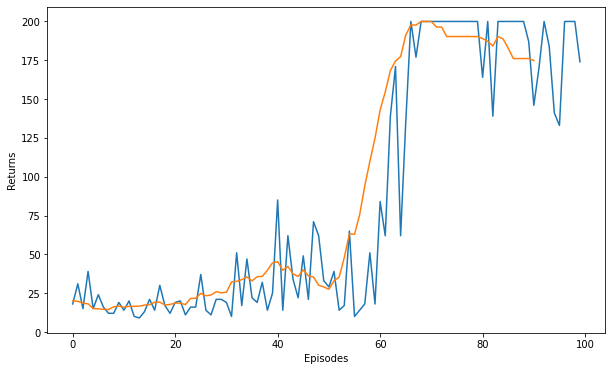

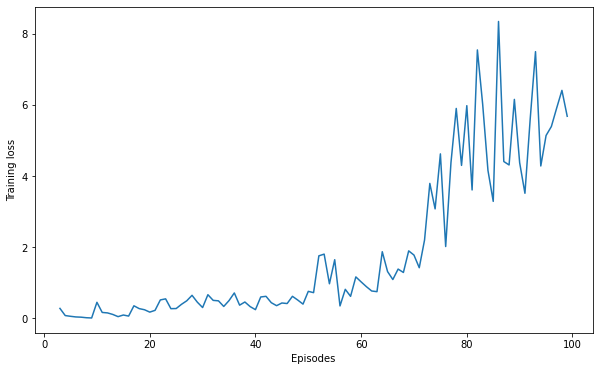

In [10]:
# Create the environment
env = gym.make('CartPole-v0')

# Create the agent
agent = DQNAgent(env, create_model, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_mean(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

In [11]:
# Test the network
nb_steps = agent.test()
print("Number of steps:", nb_steps)

Number of steps: 131


**Q:** How does the loss evolve? Does it make sense?

**A:** The Q-values are non-stationary: the initial Q-values are very small (the agent fails almost immediately), while they are around 40 after training (200 steps, but discounted with gamma). The mse increases with the magnitude of the Q-values, so the loss is a poor indicator of the convergence of the network. 

## Reward scaling

**Q:** Do a custom test trial after training (i.e. do not call test(), but copy and adapt its code) and plot the Q-value of the selected action at each time step. Do you think it is a good output for the network? Could it explain why learning is so slow?

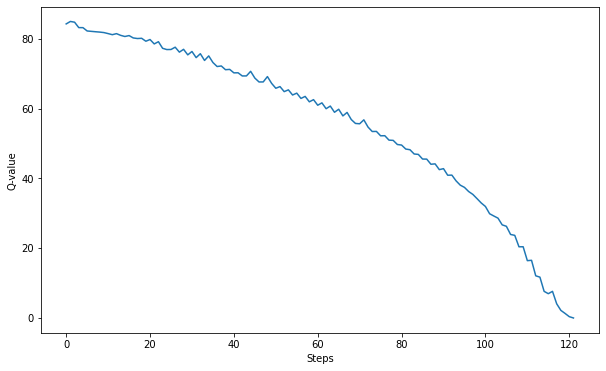

In [12]:
agent.epsilon = 0.0
        
state = agent.env.reset()
done = False

Q_values = []

while not done:
    action = agent.act(state)
    Q_values.append(agent.model.predict(state.reshape((1, 4)))[0][action])
    next_state, reward, done, info = agent.env.step(action)
    state = next_state

plt.figure(figsize=(10, 6))
plt.plot(Q_values)
plt.xlabel("Steps")
plt.ylabel("Q-value")
plt.show()

**A:** The predicted Q-values at the beginning of learning are close to 0, as the weights are randomly initialized. They must grow to around 40, which takes a lot of time. If the target Q-values were around 1, learning might be much faster.

**Q:** Implement **reward scaling** by dividing the received rewards by a fixed factor of 100 when computing the Bellman targets. That way, the final Q-values will be around 1, what may be much easier  to learned.

*Tip:* in order to avoid a huge copy and paste, you can inherit from your DQNAgent and ony reimplement the desired function:

```python
class ScaledDQNAgent (DQNAgent):
    def update(self, batch):
        # Change the content of this function only
```

You should reduce a bit the learning rate (e.g. 0.001) as the magnitude of the targets has changed. 

In [13]:
class ScaledDQNAgent(DQNAgent):
    
    def update(self, batch):
        
        # Get the minibatch
        states, actions, rewards, next_states, dones = batch 
        
        # Predict the Q-values in the current state
        targets = np.array(self.model.predict_on_batch(states))
        
        # Predict the Q-values in the next state using the target model
        next_Q_value = np.array(self.target_model.predict_on_batch(next_states)).max(axis=1)
        
        # Terminal states have a value of 0
        next_Q_value[dones] = 0.0
        
        # Compute the target
        for i in range(self.batch_size):
            targets[i, actions[i]] = rewards[i]/100. + self.gamma * next_Q_value[i]
            
        # Train the model on the minibatch
        history = self.model.fit(states, targets, epochs=1, batch_size=self.batch_size, verbose=0)
        
        return history.history['loss'][0]


Episode 100
 total steps: 9986
 length of the episode: 200
 return of the episode: 200.0
 current loss: 0.0003223761088884203
 epsilon: 0.05


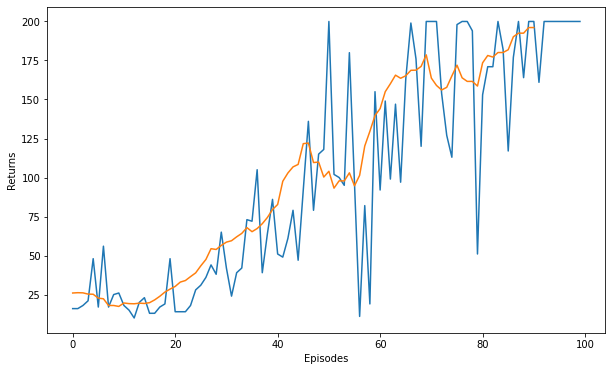

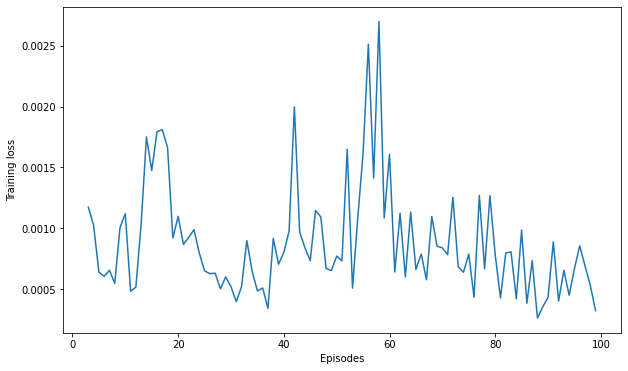

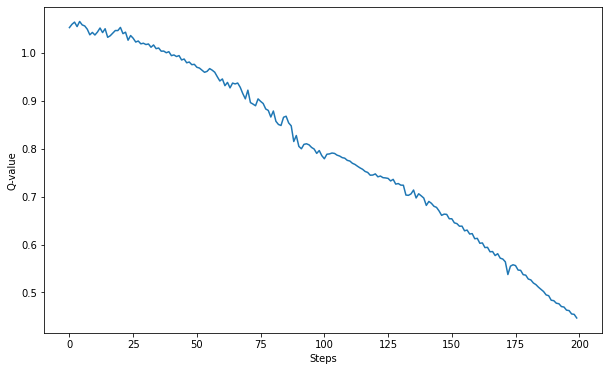

In [15]:
# Create the environment
env = gym.make('CartPole-v0')

# Create the agent
learning_rate = 0.001
agent = ScaledDQNAgent(env, create_model, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Test the network
agent.epsilon = 0.0

# Q-values     
state = agent.env.reset()
done = False
Q_values = []

while not done:
    action = agent.act(state)
    Q_values.append(agent.model.predict(state.reshape((1, 4)))[0][action])
    next_state, reward, done, info = agent.env.step(action)
    state = next_state

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_mean(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")

# Plot the Q-values
plt.figure(figsize=(10, 6))
plt.plot(Q_values)
plt.xlabel("Steps")
plt.ylabel("Q-value")
plt.show()

In [16]:
# Test the network
nb_steps = agent.test()
print("Number of steps:", nb_steps)

Number of steps: 200


**Q:** Depending on the time left and your motivation, vary the different parameters to understand their influence: learning rate, target update frequency, training update frequency, epsilon decay, gamma, etc. Change the size of the network. If you find better hyperparameters than what is proposed, please report them for next year!